In [461]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier

In [462]:
def read_csv(filename):
    data = []
    with open(filename) as file:
        reader = csv.reader(file)
        for row in reader:
            data.append(row)
    
    return data

def safe_cast_numeric(val, dtype, default=-1):
    try:
        return dtype(val)
    except (ValueError, TypeError):
        return default

In [463]:
train = read_csv("data/train.csv")
test = read_csv("data/test.csv")

cols = train[0]
rows = train[1:]

t_cols = test[0]
t_rows = test[1:]

train_df = pd.DataFrame(rows, columns=cols)
test_df = pd.DataFrame(t_rows, columns=t_cols)

In [464]:
def col_as_numeric(df_col, dtype, default_value=None):
    tmp = df_col.apply(lambda x: safe_cast_numeric(x, dtype, -1))
    
    if default_value is not None:
        tmp[tmp == -1] = dtype(default_value)
    else:
        tmp[tmp == -1] = tmp[tmp != -1].mean()

    return tmp

def explode_col(df, col):
    values = df[col].unique()
    for val in values:
        df[col+"_"+str(val)] = df[col].apply(lambda x: 1 if x == val else 0)
    return df

def clean(df):    
    # Survived
    if 'Survived' in df.columns:
        df['Survived'] = df['Survived'].astype(int)
    
    # Age
    df['Age'] = col_as_numeric(df['Age'], float)
    
    # Age bins
    bin_cuts = [0, 11, 23, 34, 45, 57, 68, 100]
    df['Age_bin'] = pd.cut(df['Age'], bin_cuts).apply(lambda x: str(x))
    actual_bins = df['Age_bin'].unique()
    for age_bin in actual_bins[:-1]:
        if age_bin == np.nan:
            continue
        df[age_bin] = df['Age_bin'].apply(lambda x: 1 if x == age_bin else 0)
    _ = df.pop('Age')

    # Sex
    sex = pd.unique(df['Sex'].unique())
    sex = pd.DataFrame(sex, columns=['Sex'])
    sex['Sex_code'] = sex['Sex'].astype('category').cat.codes
    df = pd.merge(left=df, right=sex, how='left', on='Sex')
    
    # SibSp - # of siblings / spouses aboard 
    df['SibSp'] = col_as_numeric(df['SibSp'], int, 0)
    
    # Parch - # of parents / children aboard
    df['Parch'] = col_as_numeric(df['Parch'], int, 0)
    
    # Total relatives
    df['Relatives'] = df['SibSp'] + df['Parch']
    # df = explode_col(df, 'Relatives')
    
    # # Fare
    df['Fare'] = col_as_numeric(df['Fare'], float)
    # 
    # # Pclass
    df['Pclass'] = col_as_numeric(df['Pclass'], int)
    
    # Cabin - by letter class
    df['CabinClass'] = df['Cabin'].apply(lambda x: x if len(x) == 0 else x[0])
    
    temp_df = pd.DataFrame({'CabinClass': df['CabinClass'].unique(), 
                            'CabinClass_id':range(len(df['CabinClass'].unique()))})
    df = df.merge(temp_df, on='CabinClass', how='left')
    # df = explode_col(df, 'CabinClass_id')
    # _ = df.pop('CabinClass')
    
    # Embarked
    temp_df = pd.DataFrame({'Embarked': df['Embarked'].unique(), 
                            'Embarked_id':range(len(df['Embarked'].unique()))})
    df = df.merge(temp_df, on='Embarked', how='left')
    # df = explode_col(df, 'Embarked_id')
    # _ = df.pop('Embarked')
        
    return df

df = clean(train_df)
t_df = clean(test_df)

In [465]:
for col in df.columns:
    if col not in t_df.columns:
        t_df[col] = 0

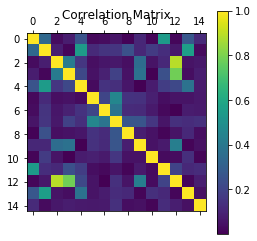

In [466]:
# Check correspondences to find any over 0.5 with survival 
corr = df.corr().abs()

plt.matshow(df.corr().abs())
cb = plt.colorbar()
plt.title('Correlation Matrix')
plt.show()

In [467]:
num_cols = df.select_dtypes('number').columns
df_numeric = df[num_cols]
df_numeric = df_numeric.dropna()
survived = df_numeric.pop('Survived')

X = df_numeric.to_numpy()
y = survived.to_numpy()

test_p = 0.9
t = int(test_p * len(y))
X_test = X[:t]
X_train = X[t:]
y_test = y[:t]
y_train = y[t:]

t_num_cols = t_df.select_dtypes('number').columns
t_df_numeric = t_df[t_num_cols]
t_df_numeric = t_df_numeric.dropna()
t_survived = t_df_numeric.pop('Survived')

X_final = t_df_numeric.to_numpy()

In [468]:
clf = svm.SVC(gamma='scale', kernel='linear', random_state=0, decision_function_shape='ovo')
clf.fit(X_train, y_train)
print("Vanilla SVC:\n- train: {}\n- test: {}".format(clf.score(X_train, y_train), 
                                                 clf.score(X_test, y_test)))

Vanilla SVC:
- train: 0.8666666666666667
- test: 0.7677902621722846


In [469]:
lin_clf = svm.LinearSVC(random_state=0)
lin_clf.fit(X_train, y_train)
print("Linear SVC:\n- train: {}\n- test: {}".format(lin_clf.score(X_train, y_train), 
                                                 lin_clf.score(X_test, y_test)))

Linear SVC:
- train: 0.8777777777777778
- test: 0.7702871410736579


/Users/blakemacnair/anaconda3/envs/titanic/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [470]:
ada_clf = AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=10, random_state=0), 
                             n_estimators=100, random_state=0)
ada_clf.fit(X_train, y_train)
print("AdaBoost, random forest:\n- train: {}\n- test: {}".format(ada_clf.score(X_train, y_train), 
                                                                 ada_clf.score(X_test, y_test)))

AdaBoost, random forest:
- train: 0.9777777777777777
- test: 0.7528089887640449


In [471]:
gr_clf = GradientBoostingClassifier(n_estimators=100, random_state=0)
gr_clf.fit(X_train, y_train)
print("Gradient Boosting, random forest:\n- train: {}\n- test: {}".format(gr_clf.score(X_train, y_train), 
                                                                          gr_clf.score(X_test, y_test)))

Gradient Boosting, random forest:
- train: 0.9777777777777777
- test: 0.7652933832709113


In [472]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
rf_clf.fit(X_train, y_train)
print("Random Forest:\n- train: {}\n- test: {}".format(rf_clf.score(X_train, y_train), 
                                                       rf_clf.score(X_test, y_test)))

Random Forest:
- train: 0.9777777777777777
- test: 0.7590511860174781


In [473]:
erf_clf = ExtraTreesClassifier(n_estimators=100, random_state=0)
erf_clf.fit(X_train, y_train)
print("Extra Trees:\n- train: {}\n- test: {}".format(erf_clf.score(X_train, y_train), 
                                                       erf_clf.score(X_test, y_test)))

Extra Trees:
- train: 0.9777777777777777
- test: 0.766541822721598


In [474]:
eclf = VotingClassifier(estimators=[('svm', clf),
                                    ('lin', lin_clf),
                                    ('ada', ada_clf), 
                                    ('grb', gr_clf),
                                    ('rfc', rf_clf),
                                    ('erf', erf_clf),
                                    ], voting='hard')
eclf.fit(X_train, y_train)
print("Voting Classifier:\n- train: {}\n- test: {}".format(eclf.score(X_train, y_train), 
                                                           eclf.score(X_test, y_test)))

/Users/blakemacnair/anaconda3/envs/titanic/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Voting Classifier:
- train: 0.9777777777777777
- test: 0.7777777777777778


In [475]:
y_final = eclf.predict(X_final)
df_final = pd.DataFrame({
    'PassengerId': t_df['PassengerId'],
    'Survived': y_final
})

df_final.to_csv("data/pred.csv", index=False)